# open-closed eye detection

In [17]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from keras import layers, models

example

In [18]:
pic=plt.imread("train\Open_Eyes\s0001_02334_0_0_1_0_0_01.png")

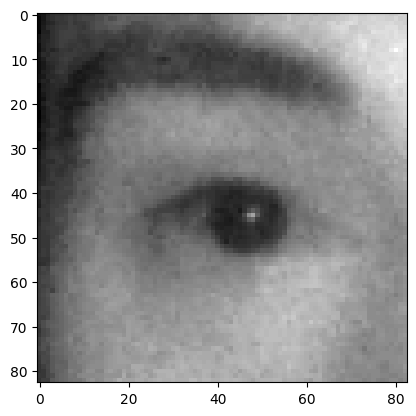

In [19]:
plt.imshow(pic, cmap="gray")

In [20]:
pic.shape

(83, 83)

In [21]:
Datadirectory = 'train'
Classes = ['Closed_Eyes', 'Open_Eyes']
img_size = 100

# Preprocessing and preparation of the data


In [22]:
def apply_data_augmentation(img):
    # Randomly flip the image horizontally
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Randomly flip the image vertically
    if random.random() > 0.5:
        img = cv2.flip(img, 0)

    # Randomly rotate the image by an angle between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))

    # Randomly shift the image horizontally and vertically by up to 10% of the image size
    shift_x = random.randint(-int(0.1 * cols), int(0.1 * cols))
    shift_y = random.randint(-int(0.1 * rows), int(0.1 * rows))
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    img = cv2.warpAffine(img, M, (cols, rows))

    return img

In [23]:

def create_training_data(Classes, Datadirectory, img_size):
    training_data = []
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

            # Resize the image while maintaining the aspect ratio
            desired_size = (img_size, img_size)
            height, width = img_array.shape
            aspect_ratio = width / height

            if aspect_ratio >= 1:
                new_width = desired_size[0]
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = desired_size[1]
                new_width = int(new_height * aspect_ratio)

            resized_image = cv2.resize(img_array, (new_width, new_height))

            # Pad the resized image to make it square (img_size x img_size)
            pad_width = (desired_size[1] - new_height) // 2
            pad_height = (desired_size[0] - new_width) // 2
            padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

            # Normalize the pixel values to [0, 1] using Minmax normalization
            normalized_image = padded_image / 255.0

            # Convert the grayscale image to RGB
            rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
            
            #perform data_augmentation
            rgb_image = apply_data_augmentation(rgb_image)
            training_data.append([rgb_image, class_num])

    print("Data processing completed.")
    return training_data

In [24]:
training_data = create_training_data(Classes, Datadirectory, img_size)

Data processing completed.


# Shuffle and reshape the data

In [25]:
random.shuffle(training_data)


In [26]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y=np.array(y)

In [27]:
Y[1]

0

# Building the 4d_model

In [28]:
# Define the input shape
input_shape = (100, 100, 3)

# Create the CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model.add(layers.Flatten())

# Add fully connected layers with specified parameters
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Adding Dropout for regularization
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Adding Dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))


In [29]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 128)       0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 256)       0         
 g2D)                                                   

In [30]:
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.fit(X,Y, epochs = 10, validation_split = 0.15)

Epoch 1/10
 45/107 [===========>..................] - ETA: 8:04 - loss: 1.3794 - accuracy: 0.5632

KeyboardInterrupt: 